# Image to Recipe Retrieval

The goal of this project is to retrieve a recipe (from a list of known recipes) given an image query and, in reverse, to retrieve an image (from a list of known images) given a text recipe. For this, the team will work on text and image retrieval by combining both modalities. In addition, the team will explore several additional textual information (title, instructions, ingredients) and analyze their impact. 

In [100]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import wandb
import tqdm
from transformers import DistilBertTokenizer, DistilBertModel

In [101]:
# GPU check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data

We use the Food Ingredients and Recipes Dataset. <br/>
The dataset consists of 13,582 images and each image comes with <br/>
(1) a corresponding title (the title of the food dish) <br/>
(2) a list of ingredients (the ingredients as they were scraped from the website) <br/>
(3) a list of instructions (the recipe instructions to be followed to recreate the dish) <br/>


## Dataset class

In [102]:
# We begin by writing a dataset class that will be used to load the data from the csv file and the images folder. 

class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_path, images_folder, transform = None):
        
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.labels = {}
        self.images = {}
        
        for index in range(len(self.df)):
            image_path = os.path.join(self.images_folder, self.df[ "Image_Name" ][index]+".jpg")
            try:
                image = PIL.Image.open(str(image_path))
                image = image.convert("RGB")
            except:
                # print("image not found - ", image_path)
                image = PIL.Image.new("RGB", (224, 224), "black")
            if not isinstance(image, PIL.Image.Image):
                image = PIL.Image.new("RGB", (224,224))
                
            self.images[index] = image
            
            label = {}
            label["Title"] = self.df[ "Title" ][index]
            label["Title"] = str(label["Title"])
            if label["Title"] == "nan":
                label["Title"] = ""
            label["Instructions"] = self.df[ "Instructions" ][index]
            label["Cleaned_Ingredients"] = self.df[ "Cleaned_Ingredients" ][index]
            
            try:
                label['2'] = str(label["Title"] + " " + label['Cleaned_Ingredients'])
            except:
                label['2'] = label["Title"]
    
            try:
                label['3'] = str(label["Title"] + " " + label['Cleaned_Ingredients'] + " " + label["Instructions"])
            except:
                label['3'] = label['2']
    
            self.labels[index] = label
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[index]
        
        return image, label

## Data Augmentation

In [103]:
# We define the transforms that will be applied to the images. 
# These allow us to augment the data and make the model more robust.

transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
        transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.1),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# mean and std of imagenet 
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # add some normalization ?
    ])  
}

## Train/Validation/Test split

In [104]:
# Fix the seed for reproducibility
torch.manual_seed(0)

In [105]:
# TODO: remove the shitty printing functions here

dataset = CustomDataset(csv_path = "data/data.csv",  images_folder = "data/images")

t, v = 0.8, 0.1
train_size, val_size, test_size = int(t * len(dataset)), int(v * len(dataset)), len(dataset) - int(t * len(dataset)) - int(v * len(dataset))
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

train_dataset.dataset.transform = transform["train"]
test_dataset.dataset.transform = transform["test"]
val_dataset.dataset.transform = transform["test"]

Title:
 Sheet-Pan Cuban Rice and Beans 

Instructions:
 Preheat the oven to 400°F. Coat a sheet pan with cooking spray.
Combine the bell peppers, onion, garlic, and oil in a medium bowl. Toss with 1/4 teaspoon of the salt. Spread the vegetables on the sheet pan and roast until somewhat softened, about 15 minutes. Remove the pan from the oven and stir.
Combine the rice, beans, cumin, oregano, fennel, coriander, remaining 3/4 teaspoon salt, and 2 1/2 cups water in a bowl. Pour the mixture onto the sheet pan, stir well, and cover with foil.
Bake until the water has been absorbed and the vegetables are tender, 28 to 30 minutes. Remove the pan from the oven and let it stand for 5 minutes. Remove the foil and fluff with a fork before serving. 

Cleaned_Ingredients:
 ['2 bell peppers, assorted colors, cut into thin strips', '1 large onion, halved through the root end and thinly sliced (about 1 1/2 cups)', '3 garlic cloves, thinly sliced', '1 tablespoon olive oil', '1 teaspoon salt, divided', 

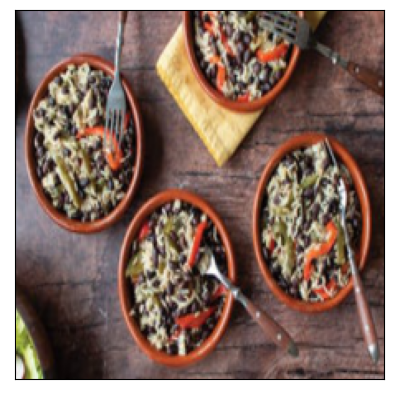

In [106]:
def show_example( dataset, index ):
    """Plot an example from the dataset.

    The example includes the image and all of its associated text data.

    Args:
        dataset: The dataset containing the example.
        index: The index of the example in the dataset.
    """
    image, label = dataset[index]
    for key, value in label.items():
        if key in ['Title', 'Instructions', 'Cleaned_Ingredients']:
            print(f"{key}:\n {value} \n")
    plt.imshow(image.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_example(dataset, np.random.randint(0, len(test_dataset)))

In [107]:
def my_collate_fn(data):
    # hacky fix for bad values in the dataset
    try :
        return torch.utils.data.dataloader.default_collate(data)
    except:
        return 0

In [108]:
# We create the dataloaders 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=my_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=my_collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=my_collate_fn)


# Model

For both cases, the model should consist of an image encoder (based on a standard CNN architecture [He2016CVPR, Simonyan2015ICLR, Tan2019ICML] or even a visual transformer [4]) and a text encoder (based on a text transformer [Vaswani2017NeurIPS] or a BERT model). You can get inspiration from the popular CLIP model from OpenAI. The model should be trained with a triplet or a contrastive loss to learn a joint embedding of text recipes and food images.


## Encoders


### Image encoders: ResNet50 and VIT_B_16

We use pretrained models from torchvision.models
We make use of the default pretrained weights for the models

In [109]:
# Encoder 1: ResNet

from torchvision.models import resnet50, ResNet50_Weights

class ResNetEncoder(nn.Module):
    def __init__(self, embedding_size, pretrained=True):
        super(ResNetEncoder, self).__init__()
        self.embedding_size = embedding_size
        self.weights = ResNet50_Weights
        if pretrained:
            self.preprocess = self.weights.transforms
            self.resnet = resnet50(weights=self.weights)
        else: 
            self.resnet = resnet50(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.embedding_size)
        self.resnet.to(device)
    
    def forward(self, images):
        images_transformed = images
        if self.preprocess is not None:
            images_transformed = self.preprocess(images)
        return self.resnet(images_transformed)

In [110]:
# Encoder 2: ViT

from torchvision.models import vit_b_16, ViT_B_16_Weights

class ViTEncoder(nn.Module):
    def __init__(self, embedding_size, pretrained=True):
        super(ViTEncoder, self).__init__()
        self.embedding_size = embedding_size
        self.vit = vit_b_16(weights= ViT_B_16_Weights)
        self.prprocess = self.vit.transforms
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, self.embedding_size)
        self.vit.to(device)
    
    def forward(self, images):
        images_transformed = images
        if self.preprocess is not None:
            images_transformed = self.preprocess(images)
        return self.vit(images_transformed)

### Text encoder : DistilBert

We use a pretrained distilbert model from huggingface transformers

In [111]:
#TODO: rename thhis to DistilBertEncoder

from transformers import DistilBertConfig, DistilBertModel

class BertEncoder(nn.Module):
    def __init__(self, embedding_size, freeze_model=True):
        super(BertEncoder, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        if freeze_model:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.bert.to(device)
        self.embedding_size = embedding_size
        self.fc = nn.Linear(self.bert.config.hidden_size, self.embedding_size)
        self.fc.to(device)
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def forward(self, tokenized_text):
        embeddings = self.bert(**tokenized_text)
        last_hidden_state = embeddings.last_hidden_state
        cls_token = last_hidden_state[:, 0, :]
        return self.fc(cls_token)
        

In [112]:
# quick check 

# embedding_size = 512
# resnet_encoder = ResNetEncoder(embedding_size = embedding_size)
# bert_encoder = BertEncoder(embedding_size = embedding_size)
# vit_encoder = ViTEncoder(embedding_size = embedding_size)

# # get some random example
# image, label = train_dataset[np.random.randint(0, len(train_dataset))]
# image = image.to(device)

# #put them through the encoders
# resnet_embedding = resnet_encoder(image.unsqueeze(0).to(device))
# vit_encodeing = vit_encoder(image.unsqueeze(0).to(device))

# tokenized_text = bert_encoder.tokenizer(label["Title"], return_tensors="pt", padding=True, truncation=True)
# bert_embedding = bert_encoder(tokenized_text.to(device))
# print(resnet_embedding.shape)
# print(bert_embedding.shape)

# Model

In [113]:
class customCLIP(nn.Module):
    def __init__(self, embedding_size, image_encoder):
        super(customCLIP, self).__init__()
        
        if image_encoder == 'vit':
            self.image_encoder =  ViTEncoder(embedding_size = embedding_size)
        elif image_encoder == 'resnet':
            self.image_encoder = ResNetEncoder(embedding_size = embedding_size)
        else:
            raise ValueError("image_encoder must be either 'resnet' or 'vit'")
        
        self.bert_encoder = BertEncoder(embedding_size = embedding_size)
        
    def encode_image(self, image):
        return self.image_encoder(image)

    def encode_text(self, text):
        return self.bert_encoder(text)
    
    def forward(self, image, text):        
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)
        return image_features, text_features
    

# Training loop and other utils

## Metrics

In [114]:
from sklearn.metrics import pairwise_distances

def compute_metrics(image_features, text_features):
    """ Function to compute Recall@1, Recall@5, MedR 
    
    image features: torch tensor of shape (batch_size, embedding_size)
    text features: torch tensor of shape (batch_size, embedding_size)
    rq : image_features and text_features should be aligned
    """
    # function from https://github.com/amzn/image-to-recipe-transformers/blob/96e257e910c79a5411c3f65f598dd818f72fc262/src/utils/metrics.py#L11
    
    image_features = image_features.cpu().detach().numpy()
    text_features = text_features.cpu().detach().numpy()
    max_k = 5
    dists = pairwise_distances(image_features, text_features, metric="cosine")
    
    try: 
        positions = np.count_nonzero(dists < np.diag(dists)[:, None], axis=-1) + 1
        rankings = np.argpartition(dists, range(max_k), axis=-1)[:, :max_k]
        positive_idxs = np.array(range(dists.shape[0]))
        cum_matches_topk = np.cumsum(rankings == positive_idxs[:, None],
                                    axis=-1)
        recall_values = np.mean(cum_matches_topk, axis=0)
        recall_1 = recall_values[0]
        recall_5 = recall_values[4]
        medr = np.median(positions)
    except:
        return 0, 0, 0
    
    return recall_1, recall_5, medr

## Training Loop

In [115]:

def train(model,  optimizer, criterion, n_epochs, device, verbose =True, use_wandb=True, exp_name='exp', text_info=1):
    
    if use_wandb:
        wandb.init(project="receipe-retrieval", name=exp_name)

    for epoch in tqdm.tqdm(range(n_epochs)):

        running_loss = 0.0
        loss_val = 0.0
        running_loss = 0.0
        for it, x in tqdm.tqdm(enumerate(train_loader)):
            
            if x == 0: # hacky way to skip bad data
                continue
            
            image, label = x
            
            if text_info == 1:
                text = label['Title']
            elif text_info == 2: # title + ingredients
                text = label['2']
            elif text_info == 3: #'title + ingredients + instructions'
                text = label['3']
            
            tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
            tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
            #todo: precompute this in the dataloader instead
            
            i_features, t_features = model(image.to(device), tokenized_text.to(device)) 
            loss = criterion(i_features, t_features)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # validate and save metrics 5 times per epoch
            if it % (len(train_loader) // 5) == 0:
                if use_wandb:
                    wandb.log({"train_loss": running_loss/ (it+1)})
                    
                print('validation')
                val_loss = 0.0
                val_recall_1 = 0.0
                val_recall_5 = 0.0
                val_medr = 0.0
            
                with torch.no_grad():
                    model.eval()
                    bad_counts = 0
                    for it, x in enumerate(val_loader):
                        
                        if x == 0:
                            continue
                        
                        image1, text1 = x
                        if text_info == 1:
                            text1 = text1['Title']
                        elif text_info == 2:    
                            text1 = text1['2']
                        elif text_info == 3:
                            text1 = text1['3']
                            
                        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
                        tokenized_text = tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
                        i_features, t_features = model(image1.to(device), tokenized_text.to(device))
                        val_loss += criterion(i_features, t_features)
                        recall_1, recall_5, medr = compute_metrics(i_features, t_features)
                        if recall_1 == 0 and recall_5 == 0 and medr == 0:
                            bad_counts += 1
                        val_recall_1 += recall_1
                        val_recall_5 += recall_5
                        val_medr += medr
                    val_loss /= len(val_loader)   
                    val_recall_1 /= (len(val_loader) - bad_counts)
                    val_recall_5 /= (len(val_loader) - bad_counts)
                    val_medr /= (len(val_loader) - bad_counts)
                    # print('val metrics, r1:{} r5:{} medr:{}'.format(val_recall_1, val_recall_5, val_medr))
                    if use_wandb:
                        wandb.log({"val_loss": val_loss.item(), "val_recall_1": val_recall_1, "val_recall_5": val_recall_5, "val_medr": val_medr})
                
        training_loss = running_loss / len(train_loader)
        validation_loss = loss_val / len(val_loader)
        validation_accuracy = 0 
        
        if verbose:
            print(f"Epoch {epoch} - Training loss: {training_loss} - Validation loss: {validation_loss}")
            
        #save the moodel every epoch
        try :
            torch.save(model.state_dict(), f"model_{exp_name}_{epoch}.pth")
        except:
            print("Could not save model")


## Losses 

In [116]:
# Original Contrastive loss
#TODO: study this better + make sure it works

class contrastive_loss(nn.Module):
    
    def __init__(self, margin=0.5):
        super(contrastive_loss, self).__init__()
        self.margin = margin
        
    def forward(self, image_features, text_features):
        image_features = image_features.view(image_features.size(0), -1)
        text_features = text_features.view(text_features.size(0), -1)
        image_features = F.normalize(image_features, p=2, dim=1)
        text_features = F.normalize(text_features, p=2, dim=1)
        similarity_matrix = torch.mm(image_features, text_features.t())
        label = torch.eye(similarity_matrix.size(0)).long().to(device)
        similarity_matrix = similarity_matrix.view(-1, 1)
        label = label.view(-1, 1)
        
        loss = (1-label) * torch.pow(similarity_matrix, 2) + \
            label * torch.pow(torch.clamp(self.margin - similarity_matrix, min=0.0), 2)
        
        return loss.mean()

In [117]:
# sum of two InfoNCE losses, ass seen in CLIP implementation
# This is the loss we will be using

class CLIP_loss(nn.Module):
    def __init__(self, margin=0.5):
        super(CLIP_loss, self).__init__()
        
        
    def forward(self, image_features, text_features):

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        labels = torch.arange(len(logits_per_image)).to(logits_per_image.device)

        image_loss = F.cross_entropy(logits_per_image, labels)
        text_loss  = F.cross_entropy(logits_per_text, labels)

        loss = (image_loss + text_loss) / 2
        return loss
    
 

In [118]:
#TODO: implement these losses

# class triplet_loss(nn.Module):
# class NTXentLoss(nn.Module):


# Training

In [119]:
# # basic init and training snippet

# model = customCLIP(embedding_size = 100, image_encoder ='resnet').to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = CLIP_loss().to(device)
# train(model, optimizer, criterion, 3, device, verbose=True, use_wandb=True, exp_name='model_name', text_info = 1)

In [120]:
# Experiments

# # criterion = contrastive_loss(margin=0.5).to(device)
# # criterion = NTXentLoss(batch_size=32, temperature=0.1, device=device).to(device)
# criterion = CLIP_loss().to(device)

# # encoder comparison
# model_vit = customCLIP(embedding_size = 100, image_encoder='vit').to(device)
# # model_resnet = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
# optimizer = torch.optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)

# # empty_cache()
# train(model_vit, optimizer, criterion, 3, device, verbose=True, use_wandb=True, exp_name='vit+clip_loss')
# # empty_cache()
# # train(model_resnet, optimizer, criterion, 3, device, verbose=True, use_wandb=True, exp_name='resnet+clip_loss')

# # # embedding size comparison
# # model_vit_20 = customCLIP(embedding_size = 20, image_encoder='vit').to(device)
# # model_vit_100 = customCLIP(embedding_size = 50, image_encoder='vit').to(device)
# # model_vit_200 = customCLIP(embedding_size = 200, image_encoder='vit').to(device)
# # empty_cache()
# # train(model_vit_20, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit_20+clip_loss')
# # empty_cache()
# # train(model_vit_100, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit_100+clip_loss')
# # empty_cache()
# # train(model_vit_200, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit_200+clip_loss')

# # # loss comparison
# # criterion1 = contrastive_loss(margin=0.5).to(device)
# # criterion2 = CLIP_loss().to(device)
# # criterion3 = NTXentLoss(batch_size=32, temperature=0.1, device=device).to(device)
# # empty_cache()
# # train(model_vit, optimizer, criterion1, 10, device, verbose=True, use_wandb=True, exp_name='vit+contrastive_loss ')
# # empty_cache()
# # train(model_vit, optimizer, criterion2, 10, device, verbose=True, use_wandb=True, exp_name='vit+clip_loss')
# # empty_cache()
# # train(model_vit, optimizer, criterion3, 10, device, verbose=True, use_wandb=True, exp_name='vit+NTXentLoss')
 
# # # text processing comparison
# # empty_cache()
# # train(model_vit, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit+clip_loss', text_info =1)
# # empty_cache()
# # train(model_vit, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit+clip_loss', text_info =2)
# # empty_cache()
# # train(model_vit, optimizer, criterion, 10, device, verbose=True, use_wandb=True, exp_name='vit+clip_loss', text_info =3)

 

In [121]:
# # load saved .pth model for next experiments

# model = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
# model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_1_2.pth'))

# Quantitative experiments


In [122]:

def compute_metrics_model(model, dataloader, text_info):
    """Compute evaluation metrics for a model on the given dataset.

    The model's performance is evaluated on tasks of text-to-image and image-to-text retrieval.

    Args:
        model: The model to evaluate.
        dataloader: A data loader that provides examples for the evaluation.
        text_info: The type of text data to use for the evaluation.

    Returns:
        A dictionary containing the computed evaluation metrics.
    """

    metrics = {'val_recall_1_tti': 0, 'val_recall_5_tti': 0, 'val_medr_tti': 0,
                'val_recall_1_itt': 0, 'val_recall_5_itt': 0, 'val_medr_itt': 0}
    
    with torch.no_grad():
                    model.eval()
                    bad_counts = 0
                    for it, x in enumerate(val_loader):
                        
                        if x == 0:
                            continue
                        
                        image1, text1 = x
                        if text_info == 1:
                            text1 = text1['Title']
                        elif text_info == 2:    
                            text1 = text1['2']
                        elif text_info == 3:
                            text1 = text1['3']
                            
                        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
                        tokenized_text = tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
                        i_features, t_features = model(image1.to(device), tokenized_text.to(device))
        
                        recall_1_tti, recall_5_tti, medr_tti = compute_metrics(i_features, t_features)
                        recall_1_itt, recall_5_itt, medr_itt = compute_metrics(t_features, i_features)
                        
                        if recall_1_tti == 0 and recall_5_tti == 0 and medr_tti == 0 and recall_1_itt == 0 and recall_5_itt == 0 and medr_itt == 0:
                            bad_counts += 1
                        metrics['val_recall_1_tti'] += recall_1_tti
                        metrics['val_recall_5_tti'] += recall_5_tti
                        metrics['val_medr_tti'] += medr_tti
                        metrics['val_recall_1_itt'] += recall_1_itt
                        metrics['val_recall_5_itt'] += recall_5_itt
                        metrics['val_medr_itt'] += medr_itt
                    metrics['val_recall_1_tti'] /= (len(val_loader) - bad_counts)
                    metrics['val_recall_5_tti'] /= (len(val_loader) - bad_counts)
                    metrics['val_medr_tti'] /= (len(val_loader) - bad_counts)
                    metrics['val_recall_1_itt'] /= (len(val_loader) - bad_counts)
                    metrics['val_recall_5_itt'] /= (len(val_loader) - bad_counts)
                    metrics['val_medr_itt'] /= (len(val_loader) - bad_counts)
                    return metrics

In [123]:
# # Comparision of models trained with different text informations

# model = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
# model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_1_2.pth'))
# metrics_1 = compute_metrics_model(model, val_loader, 1)
# print(metrics_1)

# # model = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
# model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_2_2.pth'))
# metrics_2 = compute_metrics_model(model, val_loader, 2)
# print(metrics_2)

# # model = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
# model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_3_2.pth'))
# metrics_3 = compute_metrics_model(model, val_loader, 3)
# print(metrics_3)


In [124]:
# # comparison with the vit encoder

# model = customCLIP(embedding_size = 100, image_encoder='vit').to(device)
# model.load_state_dict(torch.load('model_vit+clip(bs=16)+text_1_2.pth'))
# metrics = compute_metrics_model(model, val_loader, 1)
# print(metrics)


In [125]:
# comparison of losses (todo)

# Qualitative experiments

In [126]:
# We load a sved .pth model for next experiments

model = customCLIP(embedding_size = 100, image_encoder='resnet').to(device)
model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_1_2.pth'))

AttributeError: transforms

## Embedding space visualization

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_embedding_text(model, train_loader, device, num_batches = 30):

    """
    Visualize the embedding space for a batch of text features and their associated image.
    The model's text encoder is used to compute the embeddings. The embeddings are then plotted in 2D using PCA.

    Args:
        model: The model to use for computing the embeddings.
        train_loader: A data loader that provides examples for the visualization.
        device: The device on which the model and examples will be placed.
        num_batches: The number of batches of examples to visualize.
    """
    
    model.eval()
    with torch.no_grad():

        fig, ax = plt.subplots()
        fig.set_size_inches(21, 21) 
        
        for n in range(num_batches):
            image, text = next(iter(train_loader))
            image = image.to(device)
            # text = text["Title"]
            text = text['3']
            tokenizer =  DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

            text = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
            text = text.to(device)
            text_features = model.encode_text(text)
            pca = PCA(n_components=2)
            text_features = pca.fit_transform(text_features.cpu().numpy())
            
            # plot
            ax.scatter (text_features[:,0], text_features[:,1], color='white')
            for i, (img, txt) in enumerate(zip(image, text)):
                img = img.permute(1,2,0)
                img = img.cpu().numpy()
                ab = AnnotationBbox(OffsetImage(img, zoom=0.2), (text_features[i,0], text_features[i,1]), frameon=False, pad=0.0)
                # ax.annotate(txt, (image_features[i,0], image_features[i,1]))
                ax.add_artist(ab)
               
                
    plt.xticks([])
    plt.yticks([])  
    plt.show()

In [ ]:
def visualize_embedding_image(model, train_loader, device, num_batches = 30):
    
    """
    Visualize the embedding space for a batch of images and their associated text.

    The model's image encoder is used to compute the embeddings. The embeddings are then plotted in 2D using PCA.

    Args:
        model: The model to use for computing the embeddings.
        train_loader: A data loader that provides examples for the visualization.
        device: The device on which the model and examples will be placed.
        num_batches: The number of batches of examples to visualize.
    """
    
    model.eval()
    with torch.no_grad():

        fig, ax = plt.subplots()
        fig.set_size_inches(21, 21) 
        for n in range(num_batches):
            image, text = next(iter(train_loader))
            image = image.to(device)
            image_features = model.encode_image(image)
            pca = PCA(n_components=2)
            image_features = pca.fit_transform(image_features.cpu().numpy())
    
            # plot
            ax.scatter(image_features[:,0], image_features[:,1])
            for i, (img, txt) in enumerate(zip(image, text)):
                img = img.permute(1,2,0)
                img = img.cpu().numpy()
                ab = AnnotationBbox(OffsetImage(img, zoom=0.2), (image_features[i,0], image_features[i,1]), frameon=False, pad=0.0)
                # ax.annotate(txt, (image_features[i,0], image_features[i,1]))
                ax.add_artist(ab)
                
    plt.xticks([])
    plt.yticks([])
    plt.show()

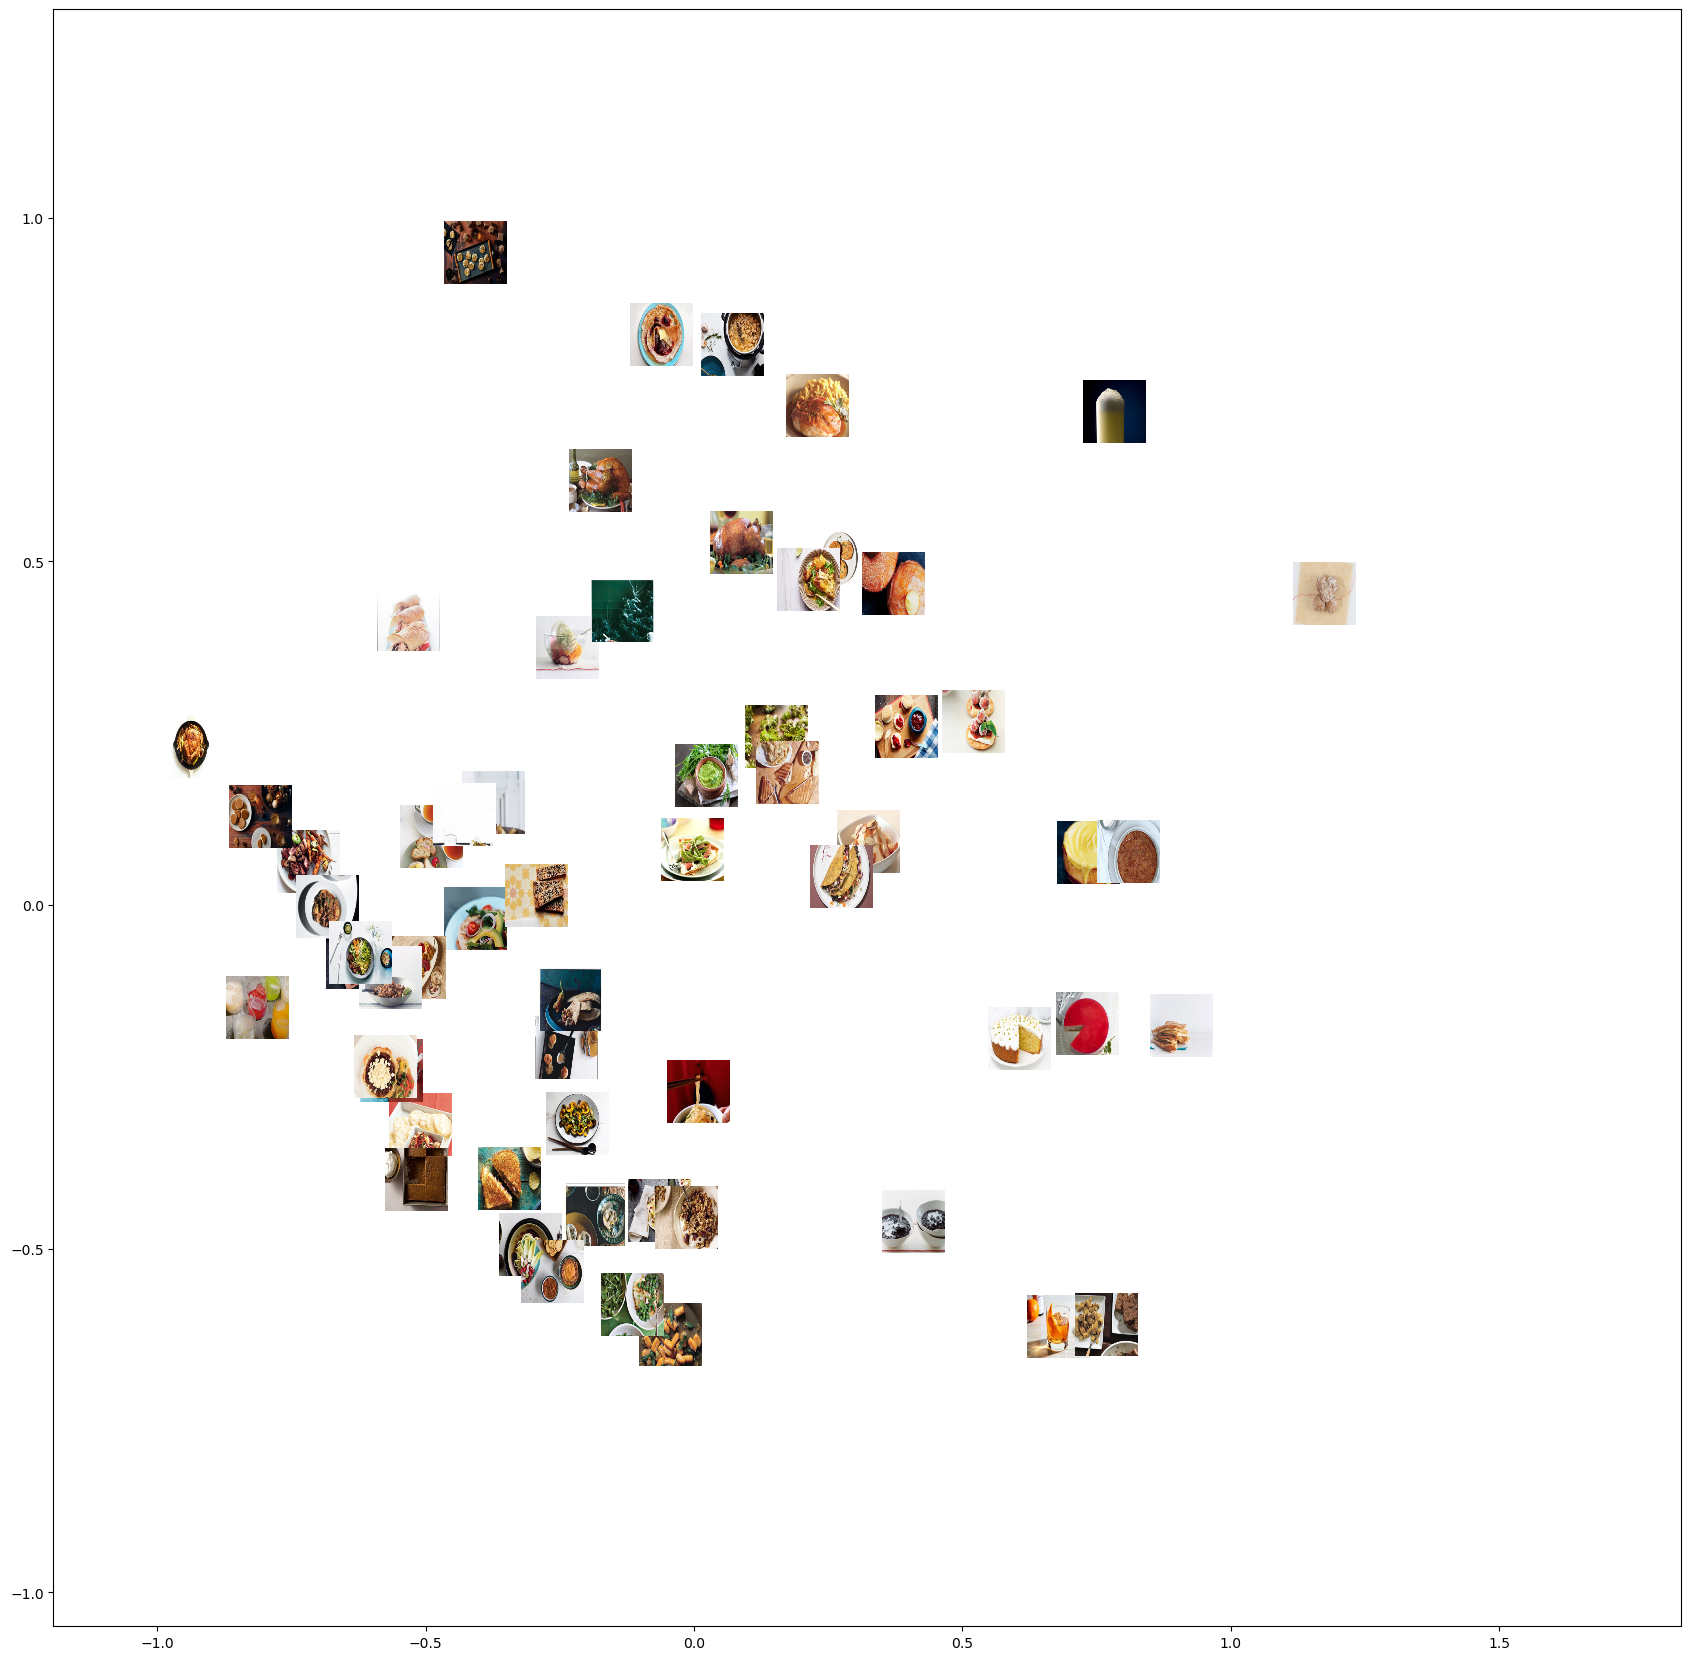

In [ ]:
visualize_embedding_image(model, train_loader, device)

In [ ]:
# TODO: make the same plot but with the text encoder
visualize_embedding_text(model, train_loader, device)

NameError: name 'visualize_embedding_text' is not defined

## Image-to-Text Retrieval


In [ ]:
# TODO: 

def text_retrieval(model, image_input, text_set, device):
    """Retrieve the most similar text to a given image query and draw a plot with the query image and a bar plot of the similarities of the different texts in the set.

    Args:
        model: The model to use for computing the embeddings.
        image_input: The image query to use for text retrieval.
        text_set: The set of texts to search for the most similar text.
        device: The device on which the model and examples will be placed.

    Returns:
        The most similar text to the given image query.
    """
    
    model.eval()
    with torch.no_grad():
        image_features = model.encode_image(image_input.to(device))
        similarities = []
        text_features = []
        
        for text in text_set:
            tokenizer = model.bert_encoder.tokenizer
            text = tokenizer(str(text), return_tensors="pt").to(device)
            text_features.append(model.encode_text(text))
            
        similarities = torch.nn.functional.cosine_similarity(image_features, torch.cat(text_features), dim=1)
        index = torch.argmax(similarities)
        most_similar_text = text_set[index]
        # print('most similar text: ', most_similar_text)
        # print('true text: ', text_set[0])
        
        # image plot
        img = image_input
        plt.subplot( 1, 2, 2)
        plt.imshow(img[0].cpu().numpy().transpose(1,2,0) )
        plt.xticks([])
        plt.yticks([])

        # bar plot
        plt.subplot( 1, 2, 1)
        similarities = similarities.cpu().numpy().reshape(-1)
        similarities = (similarities + 1) / 2
        similarities_texts = text_set
        plt.barh(similarities_texts, similarities)
        plt.title('retrieved text: ' + str(most_similar_text) + ' \n true text: ' + str(text_set[0]), loc='center')
         
        
        return most_similar_text
    


In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
image_set = []
text_set = []
for i, (image, text) in enumerate(test_loader):
    if i < 15:
        #fill the sets
        image_set.append(image)
        text_set.append(text["Title"][0])
    else:
        break

image_input 1:  torch.Size([1, 3, 224, 224])
similarities torch.Size([15])
similarities tensor([-0.0416,  0.2718,  0.0051,  0.1130,  0.0462, -0.1524,  0.0279,  0.0961,
         0.2481,  0.0845,  0.2496, -0.1678,  0.0377, -0.1769, -0.0905],
       device='cuda:0')
most similar text:  Double-Lemon Thumbprint Scones
true text:  Blue Claw Crab Boil With 3 Sauces
img shape:  torch.Size([1, 3, 224, 224])


'Double-Lemon Thumbprint Scones'

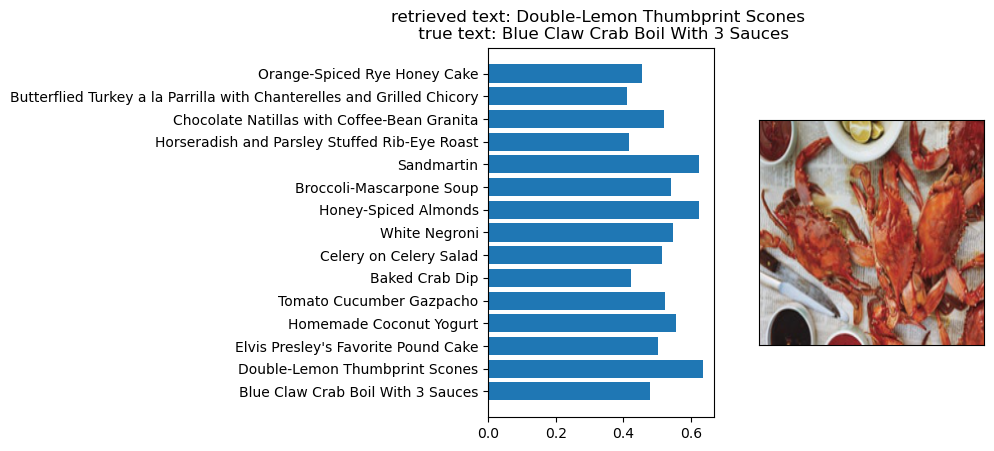

In [ ]:
image_input = image_set[0]
text_set = text_set
text_retrieval(model, image_input, text_set, device)

## Text-to-Image Retrieval

In [ ]:
# TODO: 
# - clean this function !

def image_retrieval(model, text_input, image_set, device):
    # same as before, but with images this time
    model.eval()
    with torch.no_grad():
        #put image through the network
        image_features = []
        # put all the texts through the network
        text_token = model.bert_encoder.tokenizer(str(text_input), return_tensors="pt").to(device)
        text_features = model.encode_text(text_token.to(device))
        for image in image_set:
            image_features.append(model.encode_image(image.to(device)))
      
        similarities_matrix = torch.nn.functional.cosine_similarity(torch.cat(image_features), text_features, dim=1)
        similarities = similarities_matrix
        most_similar_image = image_set[torch.argmax(similarities)]
        print('most similar image: ', most_similar_image.shape)
        print('true image: ', image_set[0].shape)
         
        # plot text, image and most similar image
        # fig, ax = plt.subplots(1,2)
        # plt.title('text_query: ', text_input)
        # image plot in the middle
        plt.subplot( 1, 2, 1)
        plt.imshow(image_set[0][0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        plt.title('true image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        # most similar image on the right
        plt.subplot( 1, 2, 2)
        plt.imshow(most_similar_image[0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        plt.title('retreieved image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        #general title
        plt.suptitle('text_query: ' + str(text_input))
        
        
        #TODO: clean that shit up !!!
        
        
        # now at the bottom, add 3 other most similar images (in order of similarity)
        i2, i3, i4, i5, i6 = torch.argsort(similarities_matrix, descending=True)[1:6]
        # plot them
        plt.figure()
        plt.suptitle('following retreived images (in order of similarity)')
        plt.subplot( 1, 5, 1)
        
        plt.imshow(image_set[i2][0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        # plt.title('2nd most similar image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        # most similar image on the right
        plt.subplot( 1, 5, 2)
        plt.imshow(image_set[i3][0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        # plt.title('3rd most similar image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        # most similar image on the right
        plt.subplot( 1, 5, 3)
        plt.imshow(image_set[i4][0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        # plt.title('4th most similar image') 
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        plt.subplot( 1, 5, 4)
        plt.imshow(image_set[i5][0].cpu().numpy().transpose(1,2,0)) 
        #subfigure title
        # plt.title('5th most similar image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])
        plt.subplot( 1, 5, 5)
        plt.imshow(image_set[i6][0].cpu().numpy().transpose(1,2,0))
        #subfigure title
        # plt.title('6th most similar image')
        #remove ticks
        plt.xticks([])
        plt.yticks([])

        #geneeral figure titlr
        
    
        # plt.title('following retreived images are in order of similarity', loc='left')



most similar image:  torch.Size([1, 3, 224, 224])
true image:  torch.Size([1, 3, 224, 224])


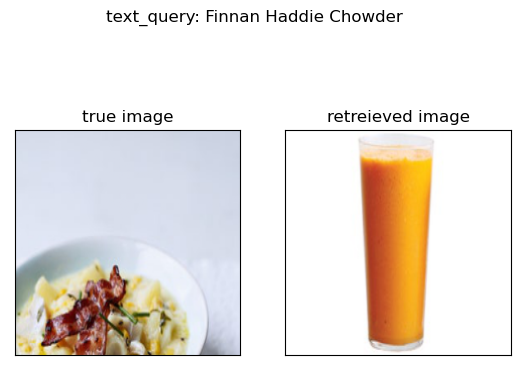

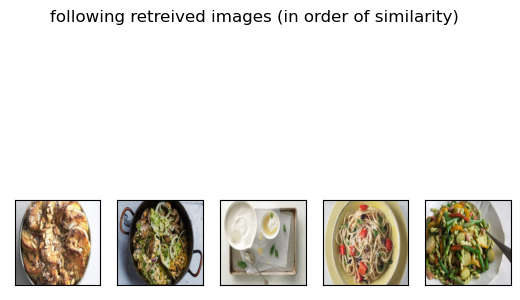

In [ ]:
image_set = []
for i, (image, text) in enumerate(test_loader):
    
    if i < 30:
        if i == 0:
            text_input = text['Title'][0]
            # instead, let' use la
            # text_input = text['2'][0]
        #fill the sets
        image_set.append(image)
    else:
        break

image_retrieval(model, text_input, image_set, device)
 

## Cosine Similarity Matrix 

In [ ]:
#we permform the experiments with our best performing model
model = customCLIP( embedding_size = 100,image_encoder='resnet').to(device)
model.load_state_dict(torch.load('model_resnet+clip(bs=16)+text_3_2.pth'))

batch = next(iter(train_loader))
batch_first = batch[:10]
images = batch[0]
texts_small = batch[1]["Title"]
texts = batch[1]["2"]
tokenizer = model.bert_encoder.tokenizer
text_tokens = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

In [ ]:

# get a batch of imagesa and texts from the test loader
from PIL import  Image

original_images = []
images = []
texts = []
test_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

batch = next(iter(test_loader_2))
images = batch[0]

texts_small = batch[1]["Title"]
texts = batch[1]['3']
original_images = [image.permute(1,2,0) for image in images]

image_input = torch.tensor(np.stack(images))
tokenizer = model.bert_encoder.tokenizer
text_tokens = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input.to(device)).float()
    text_features = model.encode_text(text_tokens.to(device)).float()
    
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

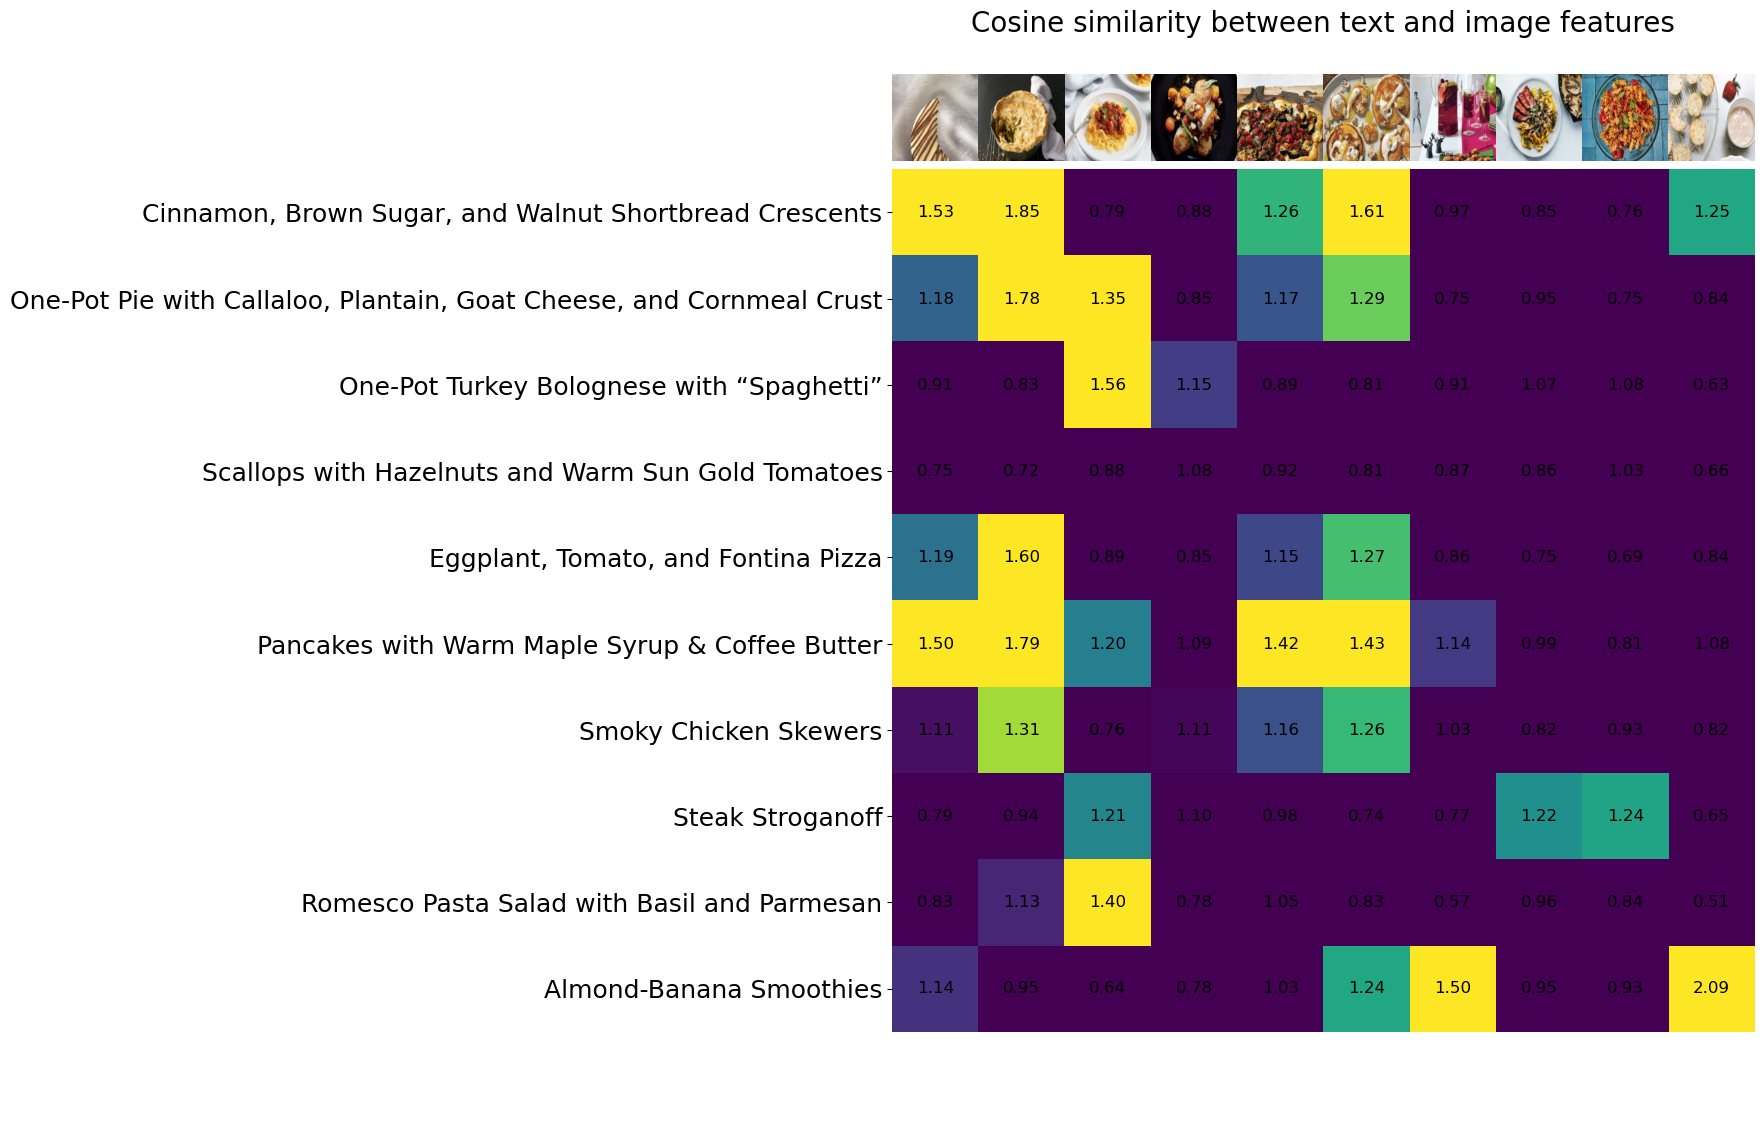

In [ ]:
#TODO: 
# - write a function for this
# - do the same for our model 

count = len(text_features)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts_small, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{np.exp(similarity[y, x]):.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)
  # change colormap
  plt.set_cmap('viridis')
  # plt.set_cmap('summer')
  # plt.set_cmap('gist_heat')
  

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
 

## Pretrained CLIP Comparison
 

Let's compare our method with a pretrained CLIP model, non finetunued on our data <br/>
The following code is adapted from https://github.com/openai/CLIP

In [ ]:
! pip install git+https://github.com/openai/CLIP.git
import clip

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from PIL import  Image

original_images = []
images = []
texts = []
for i, (image, text) in enumerate(train_loader):
    if i < 10:
        #fill the sets
        # 3convert image to PIL image
        image = image[0].permute(1,2,0)
        original_images.append(image)
        image = Image.fromarray(image.numpy(), 'RGB')
        images.append(preprocess(image))
        texts.append(text["Title"][0])
    else:
        break

image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["Photo of a " + desc for desc in texts]).cuda()


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features (Pretrained CLIP)')

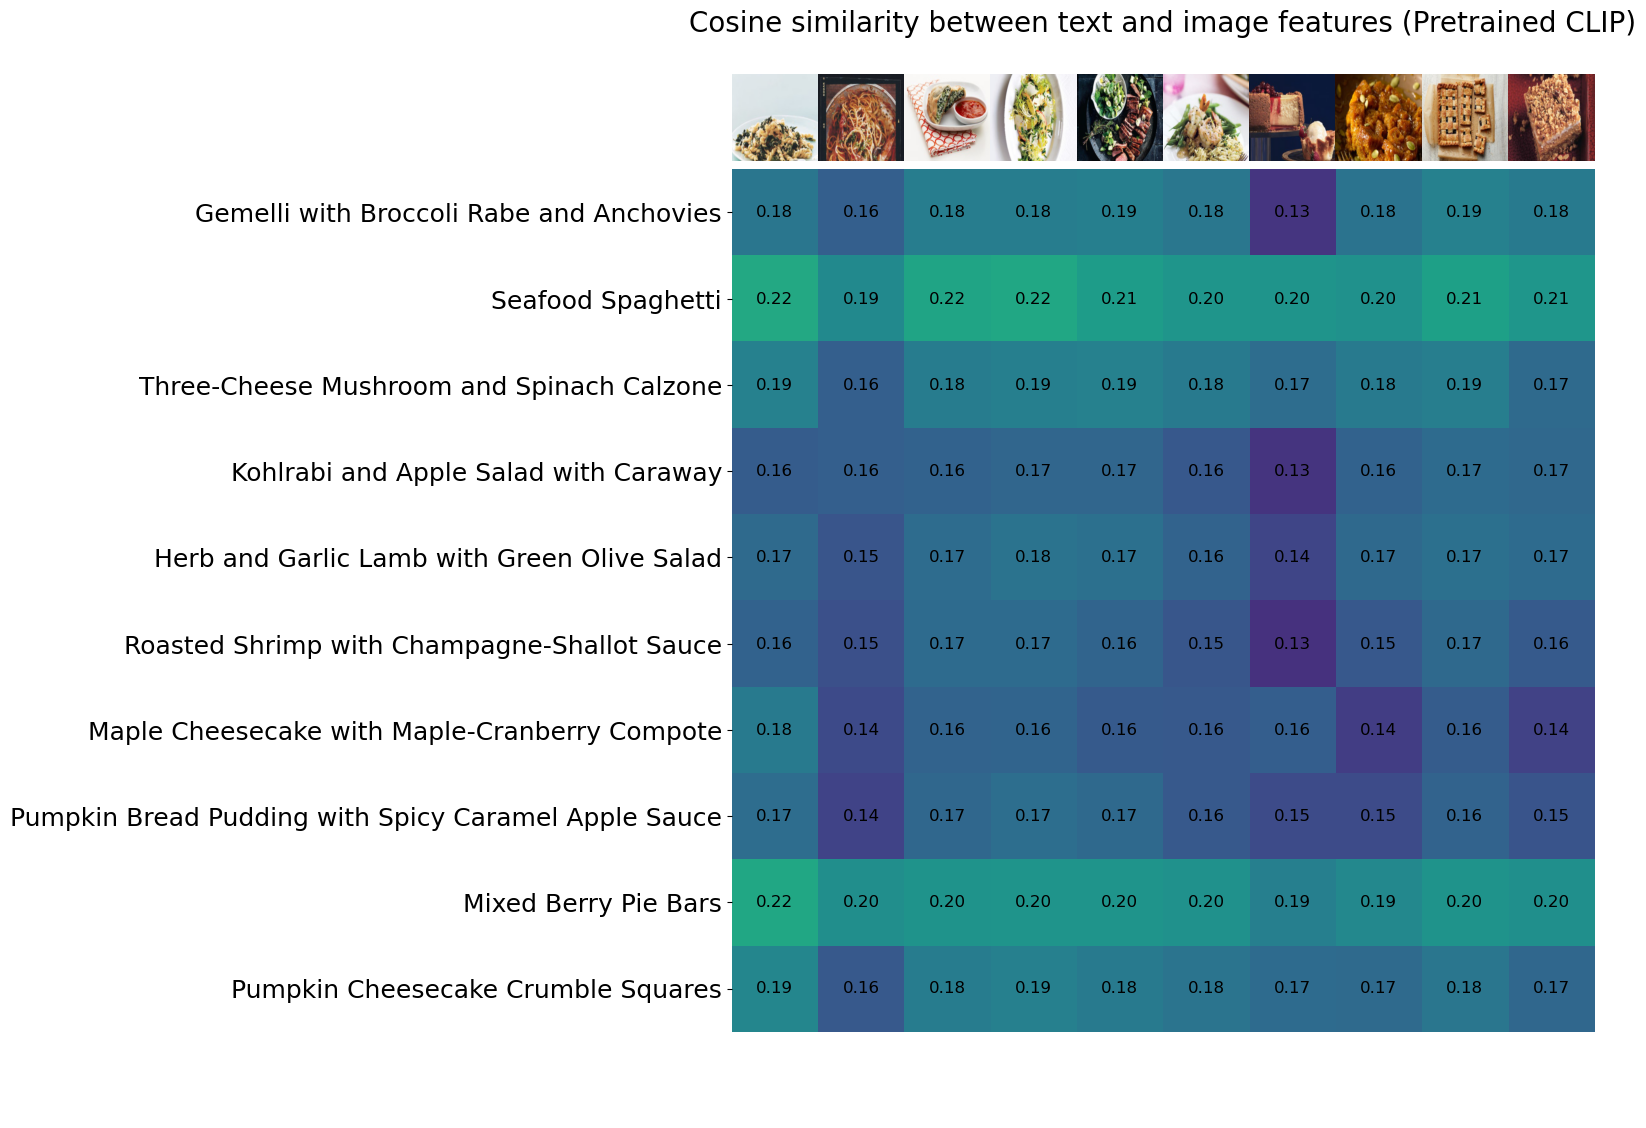

In [ ]:
#TODO: 
# - write a function for this
# - do the same for our model 

count = len(text_features)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features (Pretrained CLIP)", size=20)